In [1]:
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import os
import json
import keras_tuner

2022-12-14 16:03:31.283967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 16:03:31.284017: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Get dataset

In [ ]:
!wget gercom.ddns.net/openpose.zip

!unzip openpose.zip

In [2]:
TRAIN_DIR_PATH_JSON = os.path.join('openpose','train_out_json')
TEST_DIR_PATH_JSON = os.path.join('openpose','test_out_json')
VAL_DIR_PATH_JSON = os.path.join('openpose','val_out_json')

TRAIN_DIR_PATH_IMG = os.path.join('openpose','train_out_img')
TEST_DIR_PATH_IMG = os.path.join('openpose','test_out_img')
VAL_DIR_PATH_IMG = os.path.join('openpose','val_out_img')

TRAIN_GUNS_DIR_PATH_JSON = os.path.join(TRAIN_DIR_PATH_JSON, 'armado')
TRAIN_NOT_GUNS_DIR_PATH_JSON = os.path.join(TRAIN_DIR_PATH_JSON, 'nao_armado')
TEST_GUNS_DIR_PATH_JSON = os.path.join(TEST_DIR_PATH_JSON,'armado')
TEST_NOT_GUNS_DIR_PATH_JSON = os.path.join(TEST_DIR_PATH_JSON,'nao_armado')
VAL_GUNS_DIR_PATH_JSON = os.path.join(VAL_DIR_PATH_JSON,'armado')
VAL_NOT_GUNS_DIR_PATH_JSON = os.path.join(VAL_DIR_PATH_JSON,'nao_armado')

TRAIN_GUNS_DIR_PATH_IMG = os.path.join(TRAIN_DIR_PATH_IMG,'armado')
TRAIN_NOT_GUNS_DIR_PATH_IMG = os.path.join(TRAIN_DIR_PATH_IMG,'nao_armado')
TEST_GUNS_DIR_PATH_IMG = os.path.join(TEST_DIR_PATH_IMG,'armado')
TEST_NOT_GUNS_DIR_PATH_IMG = os.path.join(TEST_DIR_PATH_IMG,'nao_armado')
VAL_GUNS_DIR_PATH_IMG = os.path.join(VAL_DIR_PATH_IMG,'armado')
VAL_NOT_GUNS_DIR_PATH_IMG = os.path.join(VAL_DIR_PATH_IMG,'nao_armado')

In [3]:
train_img_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR_PATH_IMG, labels='inferred', 
                                                                    label_mode='binary', image_size=(256,256), shuffle=True, batch_size=4)

test_img_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR_PATH_IMG, labels='inferred', 
                                                                    label_mode='binary', image_size=(256,256), shuffle=True, batch_size=4)

val_img_dataset = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR_PATH_IMG, labels='inferred', 
                                                                     label_mode='binary',image_size=(256,256), shuffle=True, batch_size=4)

Found 23 files belonging to 2 classes.


2022-12-14 16:03:37.974320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 16:03:37.974368: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 16:03:37.974400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hodor): /proc/driver/nvidia/version does not exist
2022-12-14 16:03:37.974812: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 28 files belonging to 2 classes.
Found 64 files belonging to 2 classes.


In [4]:
classes = train_img_dataset.class_names
classes

['armado', 'nao_armado']

2022-12-14 16:03:38.860948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-14 16:03:38.882527: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz


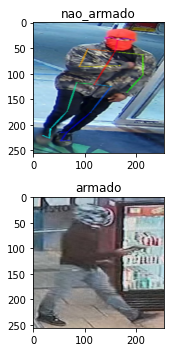

In [5]:
fig, ax = plt.subplots(nrows=2, figsize=(15,5))

img_1_ar = list(train_img_dataset.take(1))
img_2_ar = list(train_img_dataset.take(1))


img_1 = img_1_ar[0][0][0].numpy().astype("uint8")
img_2 = img_2_ar[0][0][0].numpy().astype("uint8")

ax[0].imshow(img_1)
ax[0].set_title(classes[int(img_1_ar[0][1][0])])
ax[1].imshow(img_2)
ax[1].set_title(classes[int(img_2_ar[0][1][0])])

fig.tight_layout()

# Part one: Naive classification using CNN classifier

In [33]:
def build_model(hp):
    
    kernel_sizes = hp.Choice('kernel_size', [2, 3, 4])
    n_filters_l1 = hp.Choice('filters_l1', [4, 16, 32])
    n_filters_l2 = hp.Choice('filters_l2', [32, 64, 128])
    n_filters_l3 = hp.Choice('filters_l3', [32, 64, 128, 256])

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/.255, input_shape=(256,256,3)))
    model.add(tf.keras.layers.Conv2D(n_filters_l1, kernel_sizes, strides=(1,1) ,activation='relu', use_bias=True))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(n_filters_l2, kernel_sizes, strides=(1,1) ,activation='relu', use_bias=True))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(n_filters_l3, kernel_sizes, strides=(1,1) ,activation='relu', use_bias=True))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])
    
    #model.summary()

    return model

In [34]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_loss', max_trials=15)

tuner.search(train_img_dataset, epochs=15, batch_size=4, validation_data=val_img_dataset)

final_model_params = tuner.get_best_hyperparameters()[0]

Trial 15 Complete [00h 00m 30s]
val_loss: 0.8806648254394531

Best val_loss So Far: 0.8806648254394531
Total elapsed time: 00h 07m 17s
INFO:tensorflow:Oracle triggered exit


In [35]:
final_model = build_model(final_model_params)

In [36]:
history = final_model.fit(train_img_dataset, validation_data=val_img_dataset, batch_size=4, epochs=15)

Epoch 1/15
6/6 [==============================] - 2s 352ms/step - loss: 4313.9746 - accuracy: 0.3913 - val_loss: 54.3951 - val_accuracy: 0.4844
Epoch 2/15
6/6 [==============================] - 2s 335ms/step - loss: 14.6563 - accuracy: 0.6087 - val_loss: 1.3702 - val_accuracy: 0.6094
Epoch 3/15
6/6 [==============================] - 2s 338ms/step - loss: 0.3830 - accuracy: 0.8261 - val_loss: 0.7816 - val_accuracy: 0.5312
Epoch 4/15
6/6 [==============================] - 2s 335ms/step - loss: 0.2547 - accuracy: 0.9130 - val_loss: 1.1080 - val_accuracy: 0.5938
Epoch 5/15
6/6 [==============================] - 2s 339ms/step - loss: 0.4271 - accuracy: 0.9565 - val_loss: 3.3604 - val_accuracy: 0.4844
Epoch 6/15
6/6 [==============================] - 2s 341ms/step - loss: 1.2629 - accuracy: 0.8261 - val_loss: 1.1208 - val_accuracy: 0.5156
Epoch 7/15
6/6 [==============================] - 2s 336ms/step - loss: 0.1512 - accuracy: 0.9130 - val_loss: 1.1021 - val_accuracy: 0.5469
Epoch 8/15
6/6 

In [48]:
loss, acc = history.history['loss'], history.history['accuracy']
loss_val, acc_val = history.history['val_loss'], history.history['val_accuracy']
t = np.arange(len(loss))

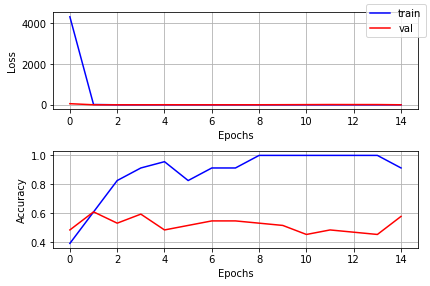

In [55]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(t, loss, c='blue', label='train')
ax[0].plot(t, loss_val, c='red', label='val')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(t, acc, c='blue')
ax[1].plot(t, acc_val, c='red')
ax[1].grid(True)
fig.legend(loc='upper right')
fig.tight_layout()

In [50]:
results = final_model.evaluate(test_img_dataset)

7/7 [==============================] - 0s 46ms/step - loss: 3.5048 - accuracy: 0.4286


<AxesSubplot:>

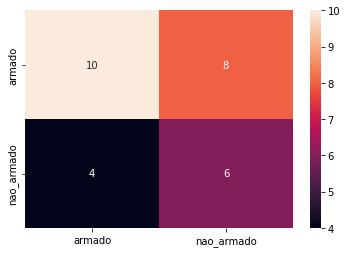

In [52]:
def to_label(l):
    if l > 0.5:
        return 1
    return 0

result_eval = final_model.predict(test_img_dataset)

result_eval = list(map(to_label, result_eval))

y = np.concatenate([y for x,y in test_img_dataset], axis=0)

cm = confusion_matrix(y, result_eval)

sns.heatmap(cm, xticklabels=['armado', 'nao_armado'], yticklabels=['armado', 'nao_armado'], annot=True)

# Part two: Categorical features

In [56]:
def build_tabular_dataset(path_gun, path_not_gun):

    gun_ar = []
    not_gun_ar = []
    for gun_file_name in os.listdir(path_gun):
        gun_file_path = os.path.join(path_gun, gun_file_name)
        with open(gun_file_path, 'r') as file:
            gun_file = json.load(file)
        if len(gun_file['people']) != 0:
            person_pose = gun_file['people'][0]['pose_keypoints_2d']
            gun_ar.append(person_pose)
        else:
            print(f"no person in the image {gun_file_name}")
    for not_gun_file_name in os.listdir(path_not_gun):
        not_gun_file_path = os.path.join(path_not_gun, gun_file_name)
        with open(not_gun_file_path, 'r') as file:
            not_gun_file = json.load(file)
        if len(not_gun_file) != 0:
            person_pose = gun_file['people'][0]['pose_keypoints_2d']
            not_gun_ar.append(person_pose)
        else:
            print(f"no person in the image {not_gun_file_name}")
    gun_df = pd.DataFrame(gun_ar)
    gun_df.loc[:, 'label'] = np.full(len(gun_df), fill_value='armado')
    not_gun_df = pd.DataFrame(not_gun_ar)
    not_gun_df.loc[:, 'label'] = np.full(len(not_gun_df), fill_value='nao_armado')
    
    df = pd.DataFrame()
    df = pd.concat([gun_df, not_gun_df])
    
    return df

In [57]:
train_df = build_tabular_dataset(TRAIN_GUNS_DIR_PATH_JSON,TRAIN_NOT_GUNS_DIR_PATH_JSON)
val_df = build_tabular_dataset(VAL_GUNS_DIR_PATH_JSON,VAL_NOT_GUNS_DIR_PATH_JSON)

no person in the image 2_keypoints.json
no person in the image 8_keypoints.json


In [85]:
X_train, y_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
X_val, y_val = val_df.iloc[:, :-1].values, val_df.iloc[:, -1].values

In [86]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [87]:
y_train = label_binarize(y_train, classes=classes)
y_val = label_binarize(y_val, classes=classes)

In [88]:
classes

['armado', 'nao_armado']

In [89]:
def build_mlp(hp):
    
    nn_hidden_l1 = hp.Choice('nn_l1',[50, 60, 70])
    nn_hidden_l2 = hp.Choice('nn_l2',[50, 60, 70])
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Input(shape=(75, )))
    model.add(tf.keras.layers.Dense(nn_hidden_l1, activation='relu'))
    model.add(tf.keras.layers.Dense(nn_hidden_l2, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
              
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])
    
    return model

In [90]:
tuner_mlp = keras_tuner.RandomSearch(build_mlp, objective='val_loss', max_trials=15)

tuner_mlp.search(x=X_train, y=y_train, epochs=15, batch_size=4, validation_data = (X_val, y_val))

final_model_mlp_params = tuner_mlp.get_best_models()[0]

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [91]:
final_model_mlp = build_mlp(tuner_mlp.get_best_hyperparameters()[0])

In [92]:
history = final_model_mlp.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), batch_size=4, epochs=15)

Epoch 1/15
5/5 [==============================] - 1s 85ms/step - loss: 0.8332 - accuracy: 0.2222 - val_loss: 1.0470 - val_accuracy: 0.1833
Epoch 2/15
5/5 [==============================] - 0s 18ms/step - loss: 0.5657 - accuracy: 0.8333 - val_loss: 0.9485 - val_accuracy: 0.2167
Epoch 3/15
5/5 [==============================] - 0s 21ms/step - loss: 0.4108 - accuracy: 0.9444 - val_loss: 0.8940 - val_accuracy: 0.2333
Epoch 4/15
5/5 [==============================] - 0s 19ms/step - loss: 0.3401 - accuracy: 0.9444 - val_loss: 0.8570 - val_accuracy: 0.2500
Epoch 5/15
5/5 [==============================] - 0s 24ms/step - loss: 0.2883 - accuracy: 0.9444 - val_loss: 0.8315 - val_accuracy: 0.2333
Epoch 6/15
5/5 [==============================] - 0s 16ms/step - loss: 0.2636 - accuracy: 0.9444 - val_loss: 0.8157 - val_accuracy: 0.2333
Epoch 7/15
5/5 [==============================] - 0s 17ms/step - loss: 0.2302 - accuracy: 0.9444 - val_loss: 0.8100 - val_accuracy: 0.2500
Epoch 8/15
5/5 [===========

In [93]:
loss_mlp, acc_mlp = history.history['loss'], history.history['accuracy']
loss_val_mlp, acc_val_mlp = history.history['val_loss'], history.history['val_accuracy']
t = np.arange(len(loss_mlp))

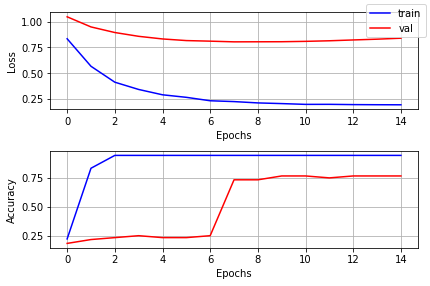

In [94]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(t, loss_mlp, c='blue', label='train')
ax[0].plot(t, loss_val_mlp, c='red', label='val')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(t, acc_mlp, c='blue')
ax[1].plot(t, acc_val_mlp, c='red')
ax[1].grid(True)
fig.legend(loc='upper right')
fig.tight_layout()

In [111]:
gun_correct, not_gun_correct = 0, 0
gun_incorrect, not_gun_incorrect = 0,0

for gun_file_name in os.listdir(TEST_GUNS_DIR_PATH_JSON):
    gun_file_path = os.path.join(TEST_GUNS_DIR_PATH_JSON, gun_file_name)
    with open(gun_file_path, 'r') as file:
        gun_file = json.load(file)
    count_people = len(gun_file['people'])
    if count_people != 0:
        is_armed = False
        for person in gun_file['people']:
            person_keypoints = scaler.transform(np.reshape(np.array(person['pose_keypoints_2d']), (1, -1)))
            r = final_model_mlp.predict(person_keypoints)
            if r < 0.5:
                gun_correct += 1
                is_armed = True
                break
        if not is_armed:
            gun_incorrect += 1
                
for not_gun_file_name in os.listdir(TEST_NOT_GUNS_DIR_PATH_JSON):
    not_gun_file_path = os.path.join(TEST_NOT_GUNS_DIR_PATH_JSON, not_gun_file_name)
    with open(not_gun_file_path, 'r') as file:
        not_gun_file = json.load(file)
    count_people = len(not_gun_file['people'])
    if count_people != 0:
        is_armed = False
        for person in not_gun_file['people']:
            person_keypoints = scaler.transform(np.reshape(np.array(person['pose_keypoints_2d']), (1, -1)))
            r = final_model_mlp.predict(person_keypoints)
            if r < 0.5:    
                not_gun_incorrect += 1
                is_armed = True
                break
        if not is_armed:
            not_gun_correct += 1

In [112]:
print(f"true positives for gun: {gun_correct}")
print(f"false positives for gun: {gun_incorrect}")
print(f"true negatives for gun: {not_gun_correct}")
print(f"false negatives for gun: {not_gun_incorrect}")

true positives for gun: 5
false positives for gun: 5
true negatives for gun: 1
false negatives for gun: 9


<AxesSubplot:>

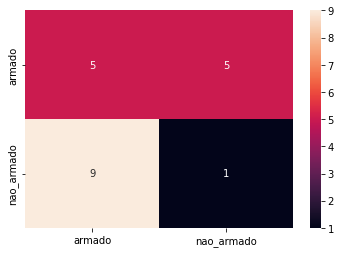

In [113]:
cm_mlp = [[gun_correct, gun_incorrect],
          [not_gun_incorrect, not_gun_correct]]
sns.heatmap(cm_mlp, xticklabels=['armado', 'nao_armado'], yticklabels=['armado', 'nao_armado'], annot=True)